In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import PIL
import torch
from torch import nn
import numpy as np
import os 
import random
import time

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cpu


In [3]:
DATA_PATH = 'clean'
DATA_PATH_X = '../input/lsautrsnew/x-data-rs'
DATA_PATH_Y = '../input/lsautrsnew/y-data-rs'
CODES_PATH = "clean/codes.txt"
BATCH_SIZE = 16
IMG_SIZE = (256)
VALID_PER = 0.8
SEED = 42
AUG_MODE=True

In [4]:
class LSNet(torch.nn.Module):
    def __init__(self):
        # call the parent constructor
        super(LSNet, self).__init__()
        self.conv_part = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=7, stride=4, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            torch.nn.Conv2d(16, 32, kernel_size=5, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            torch.nn.Conv2d(32, 64, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.deconv_part = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64, 32, kernel_size=7, stride=4, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.Upsample(scale_factor=2, mode='bilinear'),
            torch.nn.ConvTranspose2d(32, 16, kernel_size=5, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.Upsample(scale_factor=2, mode='bilinear'),
            torch.nn.ConvTranspose2d(16, 1, kernel_size=3, padding=1),
#             torch.nn.ReLU(inplace=True),
            torch.nn.Upsample(size=IMG_SIZE, mode='bilinear'),
            torch.nn.ReLU(inplace=True),
        )
    def forward(self, x):
        x = self.conv_part(x)
        x = self.deconv_part(x)
        return x

In [5]:
import os
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.label_dir = label_dir
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        name = f"{idx}.png"
        img_path = os.path.join(self.img_dir, os.listdir(self.img_dir)[idx])
        label_path = os.path.join(self.label_dir, os.listdir(self.label_dir)[idx])
        image = read_image(img_path)
        label = read_image(label_path)
        if self.transform:
            image, label = self.transform(image, label)
        return image, label

In [6]:
class MyTransform:
    def __init__(self, img_size, aug_mode=True):
        self.img_size = (img_size, img_size)
        self.aug_mode = aug_mode

    def __call__(self, img, lbl):
        rotage_angle = int(random.random()*180)
        v_flip_bool = True if random.random() > 0.5 else False
        h_flip_bool = True if random.random() > 0.5 else False
        flip_bool = (v_flip_bool, h_flip_bool)
        img = self.transform(img, rotage_angle, flip_bool)
        lbl = self.transform(lbl, rotage_angle, flip_bool)
        return img, lbl

    def transform(self, x, rotage_angle, flip_bool):
#         resized_img = transforms.Resize(size=self.img_size)
        pil_img =transforms.ToPILImage()(x)
        gray_img = transforms.functional.to_grayscale(pil_img, num_output_channels=1)
        if self.aug_mode:
            return self.augmentation(gray_img, rotage_angle, flip_bool)
        else:
            return transforms.ToTensor()(gray_img)


    def augmentation(self, img, rotage_angle, flip_bool):
        v_flip_bool, h_flip_bool = flip_bool
        aug_img = transforms.functional.rotate(img, rotage_angle)
        if v_flip_bool:
            aug_img = transforms.functional.vflip(aug_img)
        if h_flip_bool:
            aug_img = transforms.functional.vflip(aug_img)            
        return transforms.ToTensor()(aug_img)


In [7]:
model_path = 'models\main\good\model_08_10_08_03.pth'
model = LSNet()
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [8]:
DATA_PATH_X = 'clean/x-data-rs'
DATA_PATH_Y = 'clean/y-data-rs'

In [9]:
i = 1
eval_dset  = CustomImageDataset(DATA_PATH_X, DATA_PATH_Y, transform=MyTransform(IMG_SIZE, aug_mode=False))
x, y = eval_dset[i][0], eval_dset[i][1]
model.eval()
print(x.shape)
print(y.shape)
with torch.no_grad():
    pred = model(x[None,:].to(device))
    
new_pred = pred[0]    


torch.Size([1, 256, 256])
torch.Size([1, 256, 256])


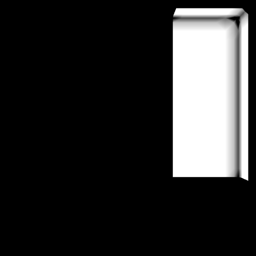

In [10]:
transforms.ToPILImage()(x)

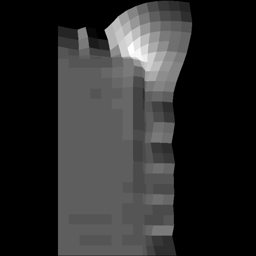

In [11]:
transforms.ToPILImage()(y)

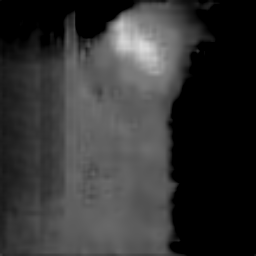

In [12]:
transforms.ToPILImage()(new_pred)

In [13]:
lr = 10e-3
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=lr,
    weight_decay = 1e-8)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [14]:
t_loss = torch.sqrt(loss_fn(y.to(device), new_pred))
1-t_loss.item()

0.8944775462150574

In [15]:
t_loss.item()*100

10.552245378494263

In [17]:
eval_tfs = MyTransform((IMG_SIZE))

y_cont = []
x_cont = []
for _ in range(9):
    x_t, y_t = eval_tfs(x,y)
    y_cont.append(y_t)
    x_cont.append(x_t)

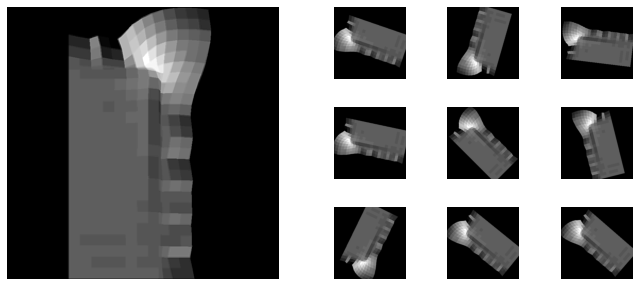

In [18]:
fig = plt.figure(figsize=(12,5))
grid = plt.GridSpec(3, 6,figure = fig, wspace=0.1, hspace=0.4)
ax0 = fig.add_subplot(grid[0:3, 0:3])
ax0.imshow(y[0], cmap='gray')
ax0.axis('off')
h = 0
for i in range(3):
    for j in range(3, 6):
        axf = fig.add_subplot(grid[i, j])
        axf.imshow(y_cont[h][0], cmap='gray')
        axf.axis('off')
        h += 1

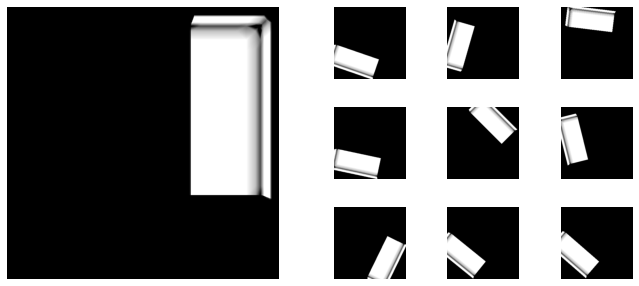

In [19]:
fig = plt.figure(figsize=(12,5))
grid = plt.GridSpec(3, 6,figure = fig, wspace=0.1, hspace=0.4)
ax0 = fig.add_subplot(grid[0:3, 0:3])
ax0.imshow(x[0], cmap='gray')
ax0.axis('off')
h = 0
for i in range(3):
    for j in range(3, 6):
        axf = fig.add_subplot(grid[i, j])
        axf.imshow(x_cont[h][0], cmap='gray')
        axf.axis('off')
        h += 1